## Data Cleaning

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as stats

import statsmodels.api as sm
import statsmodels.formula.api as smf

data = pd.read_csv('googleplaystore.csv')
data.head()

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up


We will remove the last 3 columns in order to save space and computation time, as they will not be used for any of our analyses. We will also remove `Genres` in favor of the simpler column `Category`, as many of the categories and genres are identical.

In [3]:
data = data.iloc[:,:-4]

Before we can perform our EDA, we will need to clean our data by setting the proper dtypes for the following columns:
* Numbers should either be `float` or `int`, and any trailing symbols should be removed
* Nominal variables should be binarized or one-hot encoded

In [4]:
data.dtypes

App                object
Category           object
Rating            float64
Reviews            object
Size               object
Installs           object
Type               object
Price              object
Content Rating     object
dtype: object

`Reviews`, `Size`, `Installs`, and `Price` will be converted to `int` or `float`. \
`Category`, `Type`, and `Content Rating` will be converted into `category`.

In [5]:
data[data['Reviews'].str.contains("[.]")]

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating
10472,Life Made WI-Fi Touchscreen Photo Frame,1.9,19.0,3.0M,"1,000+",Free,0,Everyone,NaN


There is one row that is missing its `Category`, causing all of the data to shift to the left. While we could fix this issue manually, it is safer to remove the row.

In [6]:
#Drop the unwanted column
data = data.drop(10472).reset_index(drop=True)

#Convert columns into usable dtypes
data['Reviews'] = data['Reviews'].astype(int)
data['Installs'] = data['Installs'].str.replace('+', '').str.replace(',', '').astype(int)
data['Price'] = data['Price'].str.replace('$', '').astype(float)

def convert_size(size):
    if 'M' in size:
        return float(size.replace('M', ''))
    elif 'k' in size:
        return float(size.replace('k', '')) / 1000
    else:
        return np.nan

data['Size'] = data['Size'].apply(convert_size)
data['Category'] = data['Category'].astype('category')
data['Type'] = data['Type'].astype('category')
data['Content Rating'] = data['Content Rating'].astype('category')

C:\Users\zhiai\AppData\Local\Temp\ipykernel_18068\2827623927.py:6: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  data['Installs'] = data['Installs'].str.replace('+', '').str.replace(',', '').astype(int)
C:\Users\zhiai\AppData\Local\Temp\ipykernel_18068\2827623927.py:7: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  data['Price'] = data['Price'].str.replace('$', '').astype(float)


Now that we have modified the dtypes, we can move on to the next step: Checking cells for missing values.

In [7]:
data.isna().sum()

App                  0
Category             0
Rating            1474
Reviews              0
Size              1695
Installs             0
Type                 1
Price                0
Content Rating       0
dtype: int64

The cell above indicates that there are 1474 apps without a rating.
Since we are looking to determine a relationship between app installations based on app ratings, we will have to remove these.

In [8]:
data = data[data["Rating"].notna()]

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9366 entries, 0 to 10839
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   App             9366 non-null   object  
 1   Category        9366 non-null   category
 2   Rating          9366 non-null   float64 
 3   Reviews         9366 non-null   int32   
 4   Size            7729 non-null   float64 
 5   Installs        9366 non-null   int32   
 6   Type            9366 non-null   category
 7   Price           9366 non-null   float64 
 8   Content Rating  9366 non-null   category
dtypes: category(3), float64(3), int32(2), object(1)
memory usage: 468.1+ KB


There are still 1637 rows with no `Size` data; however, removing these datapoints would significantly alter most hypothesis tests, so we choose to keep them. Should we decide to explore a hypothesis test using app size, we will perform mean imputation by category to determine an ideal estimate.

## EDA - Univariate Analysis

Now we can perform our EDA. For our first step, we will perform univariate analyses, starting with the distribution of app ratings.

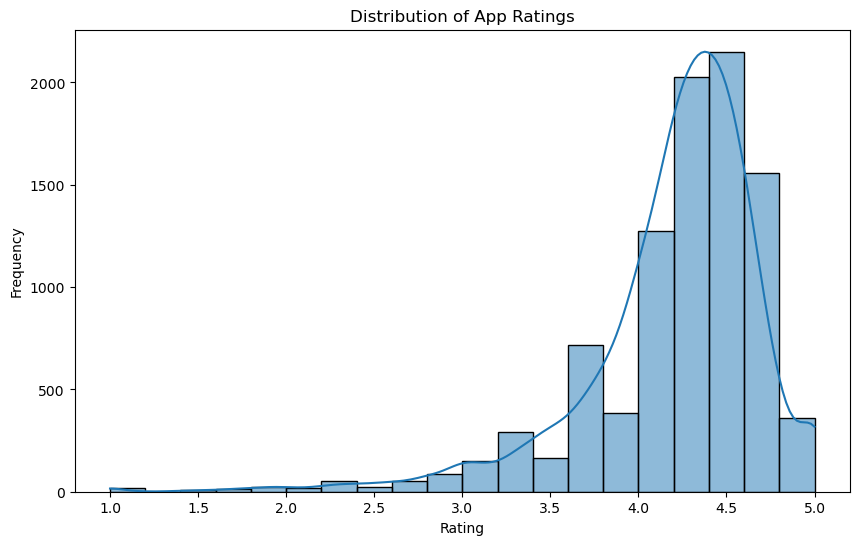

In [10]:
plt.figure(figsize=(10, 6))
sns.histplot(data['Rating'].dropna(), bins=20, kde=True)
plt.title('Distribution of App Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()

Based on our distribution, we can deduce that the ratings are not uniformly distributed, concentrated between 4 and 5 star reviews, and skewed to the left. \
Now, let's look at the distribution of apps based on the number of installations.

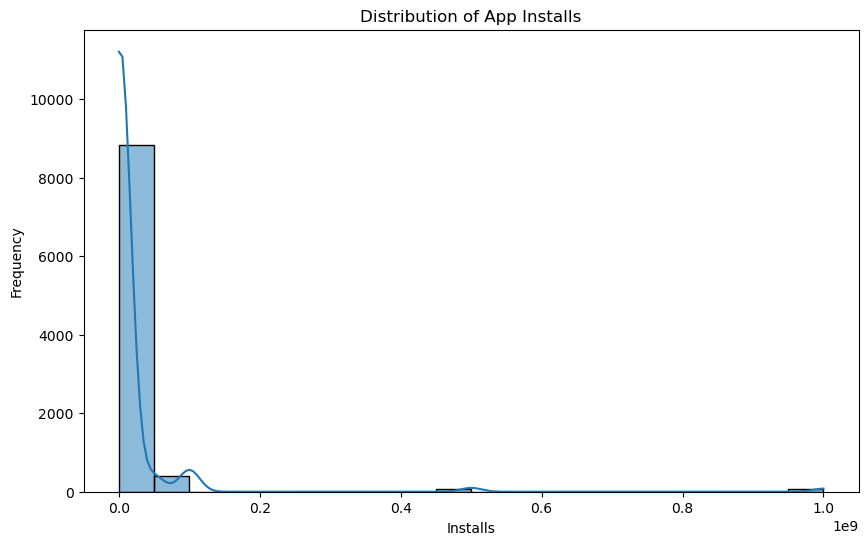

In [11]:
plt.figure(figsize=(10, 6))
sns.histplot(data['Installs'], bins=20, kde=True)
plt.title('Distribution of App Installs')
plt.xlabel('Installs')
plt.ylabel('Frequency')
plt.show()

Based on the plot above, we can see that the distribution of installations is skewed to the right, with most apps having less than 1 million installations. Why does our plot look so skewed? It turns out that the values in `Installs` are not accurate counts of the number of installations, but instead are **categories**, with each category increasing by a multiple of $.5e+$.

When working with skewed data distributions, outliers are detrimental to our hypothesis tests as well as for regression models. \
What if we instead binned apps based on the number of downloads? By Changing the `Installs` to a categorical dtype and getting the number of apps in each category, we can create a plot that resembles more closely a normal distribution.

C:\Users\zhiai\AppData\Local\Temp\ipykernel_18068\2391978112.py:4: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  data['Installs'] = data['Installs'].str.replace('+', '').str.replace(',', '').astype(int)
C:\Users\zhiai\AppData\Local\Temp\ipykernel_18068\2391978112.py:5: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  data['Price'] = data['Price'].str.replace('$', '').astype(float)


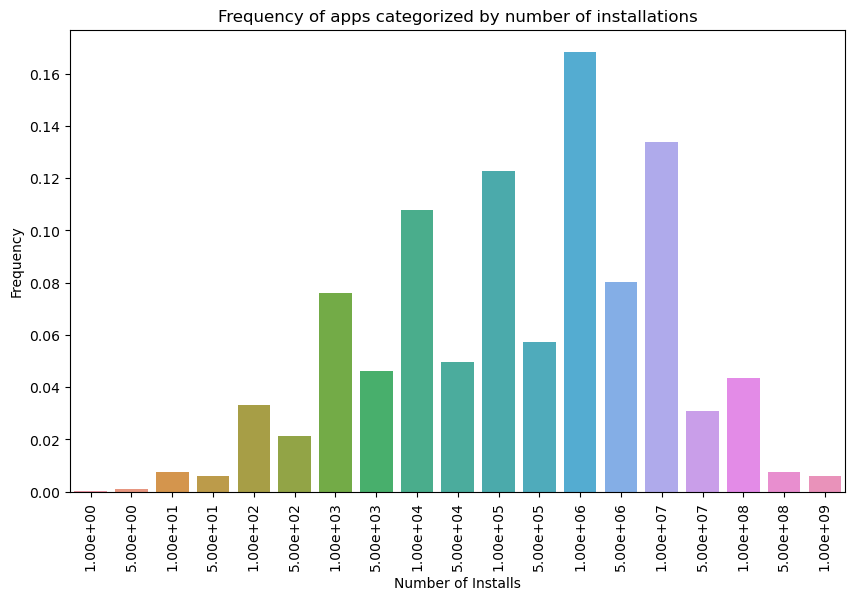

In [12]:
data = pd.read_csv('googleplaystore.csv')
data = data.dropna()
data['Reviews'] = data['Reviews'].astype(int)
data['Installs'] = data['Installs'].str.replace('+', '').str.replace(',', '').astype(int)
data['Price'] = data['Price'].str.replace('$', '').astype(float)

def convert_size(size):
    if 'M' in size:
        return float(size.replace('M', ''))
    elif 'k' in size:
        return float(size.replace('k', '')) / 1000
    else:
        return np.nan
data['Size'] = data['Size'].apply(convert_size)
data['Category'] = data['Category'].astype('category')

q = (data["Installs"].value_counts().sort_index() / 
     data["Installs"].shape[0]).to_frame().reset_index()
q.columns = ["Number of Installs", "Frequency"]
q["Number of Installs"] = q["Number of Installs"].apply(lambda x: format(int(x), ".2e"))

plt.figure(figsize=(10, 6))
sns.barplot(data=q, x="Number of Installs", y="Frequency")
plt.xticks(rotation=90)
plt.ylabel("Frequency")
plt.title("Frequency of apps categorized by number of installations")
plt.show()

## EDA - Bivariate Analysis

To start our analyses, we examined the relationship between app rating, and the total number of reviews

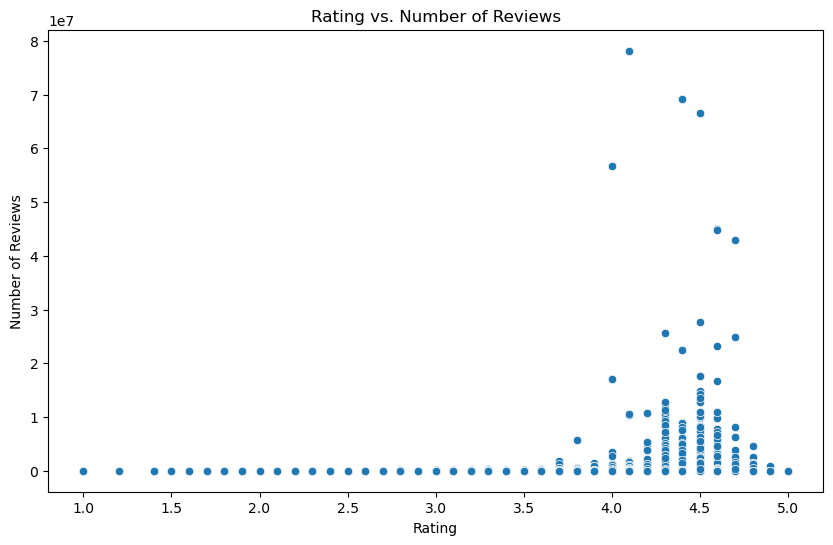

In [13]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Rating', y='Reviews', data=data)
plt.title('Rating vs. Number of Reviews')
plt.ylabel('Number of Reviews')
plt.xlabel('Rating')
plt.show()

Looking at the plot above, we start to notice a few patterns between the variables:
* Apps that are rated low tend to have less reviews than apps with higher ratings. This is due to many reason, one of the more likely reasons is that people are put off by apps that have low ratings; therefore, there are less people to try the app and give it a review.
* The above statement is also corroborated by the low installations for low-rated apps
* Successful apps (those with hundreds of millions of installations) do not correspond with the highest ratings. This is because there is a higher population percentage that is experiencing app flaws that are likely to make users submit negative reviews. 

Instead of performing multiple multivariate analyses, we san perform a correlation matrix to determine if there is colinnearity between any of the quantitative variables. The results are shown in the matrix below:

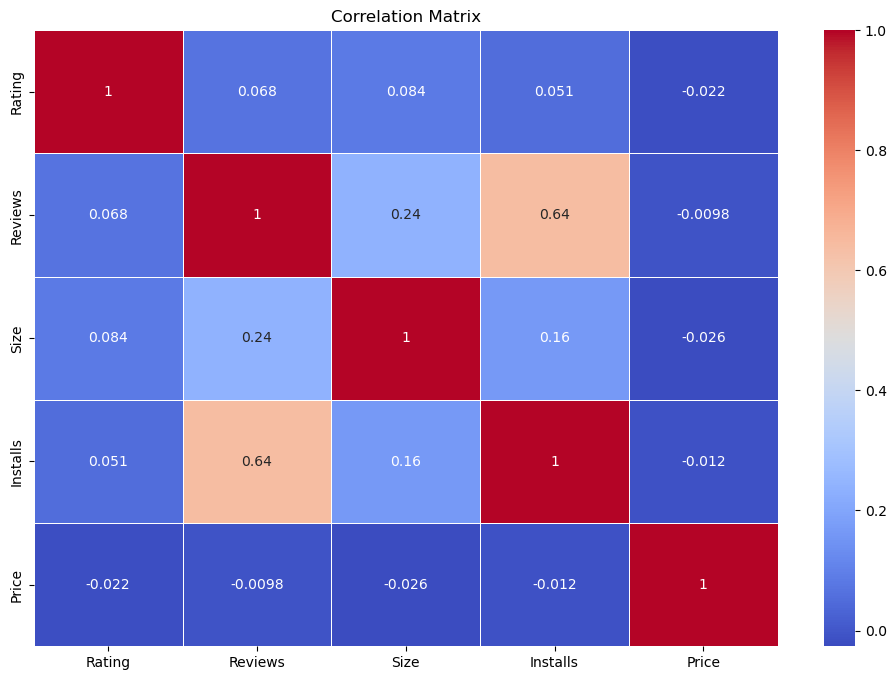

In [14]:
correlation_matrix = data.drop(["App", "Category", "Type", "Content Rating"], axis= 1).corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

# Hypothesis Testing

### Hypothesis Test #1

Now that we have deduced that there may be a correlation between reviews and installs, lets determine just how significant other links are. We will determine if there is collinearity between 2 different categories based on `Rating`. We start by answering the following question:

> Is there a correlation between the distribution of ratings based on the catgories `COMMUNICATION` and `GAME`?

We will answer this question using the following hypotheses:

> Null Hypothesis $H_0$: `COMMUNICATION` and `GAME` have similar mean values. \
> Alternate Hypothesis $H_a$:  `COMMUNICATION` and `GAME` do not have the same means.

In [15]:
#Prepare the DataFrame
com_game_df = data[(data["Category"] == "COMMUNICATION") | (data["Category"] == "GAME")].reset_index(drop= True)
com_game_df["Installs"] = com_game_df["Installs"].apply(lambda x: format(x, ".2e"))
df_desc = com_game_df.groupby("Category", observed= True)["Rating"].describe()
df_desc

,count,mean,std,min,25%,50%,75%,max
Category,,,,,,,,
COMMUNICATION,328.0,4.158537,0.426192,1.0,4.0,4.3,4.4,5.0
GAME,1097.0,4.286326,0.365375,1.0,4.1,4.4,4.5,5.0


Under the following hypotheses, we will perform Welch's 2-tailed t-test to determine if the two distributions have a difference in means. Welch's t-test is useful for determining whether 2 samples come from the same distribution, and when the sample sizes are different.

In [16]:
#Perform Welch's t-test
x1 = com_game_df[com_game_df["Category"] == "COMMUNICATION"]["Rating"]
x2 = com_game_df[com_game_df["Category"] == "GAME"]["Rating"]
tval, pval = stats.ttest_ind(x1, x2, equal_var=False)

def p_test(pval, alpha= 0.01):
    print("p-value: " + str(pval))
    if pval < alpha:
        print("Reject H_0")
    else:
        print("Fail to reject H_0:")

p_test(pval)

p-value: 1.2095995057771276e-06
Reject H_0


### Hypothesis test #2

Since our null hypothesis was rejected when testing for difference in means, let's determine if there are any correlations between two categories using the Komolgorov-Smirnov Test.

> Is there a correlation between the distribution of ratings based on the catgories `COMMUNICATION` and `GAME`?

We will answer this question using the following hypotheses:

> Null Hypothesis $H_0$: `COMMUNICATION` and `GAME` come from the same distribution. \
> Alternate Hypothesis $H_a$:  `COMMUNICATION` and `GAME` do not come from the same distribution

In [17]:
#Perform the K-S test
x1 = com_game_df[com_game_df["Category"] == "COMMUNICATION"]["Rating"]
x2 = com_game_df[com_game_df["Category"] == "GAME"]["Rating"]
tval, pval = stats.ks_2samp(x1, x2)

def p_test(pval, alpha= 0.01):
    print("p-value: " + str(pval))
    if pval < alpha:
        print("Reject H_0")
    else:
        print("Fail to reject H_0:")

p_test(pval)

p-value: 5.651039581432086e-10
Reject H_0


Once again, out test statistic reveals that there is a statistical significance in the difference in distributions between our two observed categories. We reject the nul hypothesis and claim that the two distributions are indeed not comming from the same distribution.

Below we plot the normalized distributions for `GAME` and `COMMUNICATION`

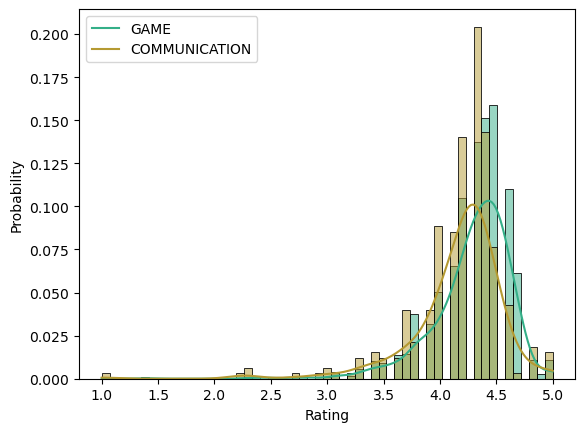

In [18]:
fig = sns.histplot(com_game_df, x= "Rating", hue= "Category", kde=True, stat= "probability", common_norm= False)
plt.legend(["GAME", "COMMUNICATION"])
plt.show()

We can deduce the following from the 2 hypothesis tests we performed as well as the plot shown above:
* Although visually the two distributions seem very close, our sample sizes were large enough that this difference was statistically significant.
* The variance of `COMMUNICATION` is significantly greater than variance of `GAME`, resulting in a CDF plot showing the distribution of `COMMUNICATION` as "tail heavy"
* The correlation matrix had a coefficient of $0.051$ for the `Rating` and `Installs` cell. These hypothesis tests both stengthen the validity of the claim that these two variables are uncorrelated.

<b></b>


<b></b>

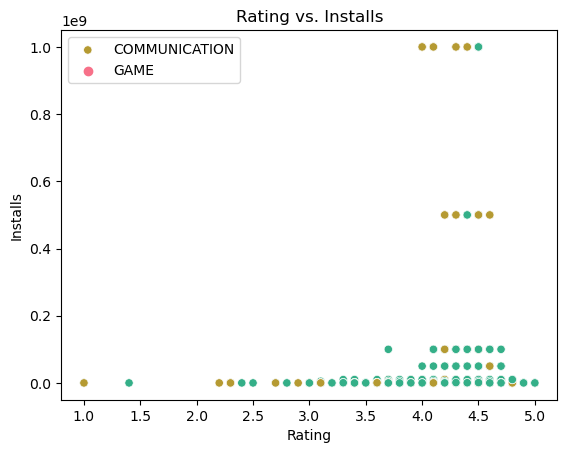

In [19]:
ins_rat_df = com_game_df.copy()
ins_rat_df["Installs"] = ins_rat_df["Installs"].astype(float).astype(int)
ins_rat_df = ins_rat_df[["Category", "Rating", "Installs"]]
sns.scatterplot(x= "Rating", y= "Installs", hue="Category", data= ins_rat_df)
plt.legend(["COMMUNICATION", "GAME"])
plt.title("Rating vs. Installs")
plt.show()

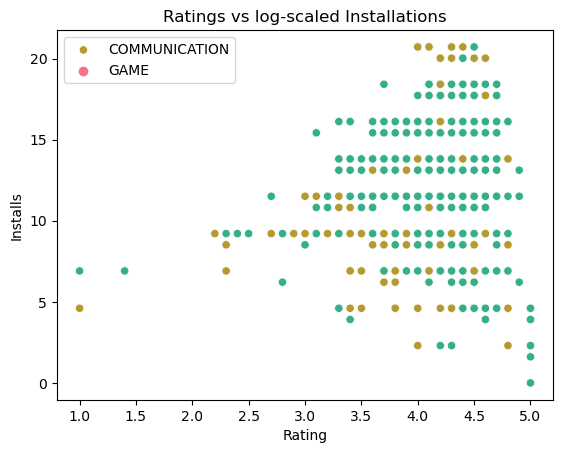

In [20]:
logged_df = com_game_df.copy()
logged_df["Installs"] = logged_df["Installs"].astype(float).astype(int).apply(lambda x: np.log(x))
logged_df = logged_df[["Category", "Rating", "Installs"]]
sns.scatterplot(x= "Rating", y= "Installs", hue="Category", data= logged_df)
plt.legend(["COMMUNICATION", "GAME"])
plt.title("Ratings vs log-scaled Installations")
plt.show()

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso, Ridge, ElasticNet
from scipy.stats import ttest_ind, ks_2samp

# Load and clean data
data = pd.read_csv('googleplaystore.csv')
data = data.dropna()
data['Reviews'] = data['Reviews'].astype(int)
data['Installs'] = data['Installs'].str.replace('+', '').str.replace(',', '').astype(int)
data['Price'] = data['Price'].str.replace('$', '').astype(float)

def convert_size(size):
    if 'M' in size:
        return float(size.replace('M', ''))
    elif 'k' in size:
        return float(size.replace('k', '')) / 1000
    else:
        return np.nan

data['Size'] = data['Size'].apply(convert_size)
data['Category'] = data['Category'].astype('category')
data['Type'] = data['Type'].astype('category')
data['Content Rating'] = data['Content Rating'].astype('category')

C:\Users\zhiai\AppData\Local\Temp\ipykernel_18068\1992730474.py:16: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  data['Installs'] = data['Installs'].str.replace('+', '').str.replace(',', '').astype(int)
C:\Users\zhiai\AppData\Local\Temp\ipykernel_18068\1992730474.py:17: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  data['Price'] = data['Price'].str.replace('$', '').astype(float)


In [22]:
# Frequency distribution of installations
q = (data["Installs"].value_counts().sort_index() / 
     data["Installs"].shape[0]).to_frame().reset_index()
q.columns = ["Number of Installs", "Frequency"]
q["Number of Installs"] = q["Number of Installs"].apply(lambda x: format(x, ".2e"))
q

,Number of Installs,Frequency
0,1.00e+00,0.000321
1,5.00e+00,0.000962
2,1.00e+01,0.007372
3,5.00e+01,0.005983
4,1.00e+02,0.033013
5,5.00e+02,0.021474
6,1.00e+03,0.076068
7,5.00e+03,0.046047
8,1.00e+04,0.107799
9,5.00e+04,0.049786


In [23]:
# Goodness of Fit Test
from scipy.stats import chi2_contingency

# Create a contingency table for observed frequencies
observed_freq = pd.crosstab(index=data['Category'], columns='count')
expected_freq = observed_freq.sum(axis=0) * observed_freq.sum(axis=1) / observed_freq.values.sum()

# Chi-square test for goodness of fit
chi2_stat, p_val, dof, expected = chi2_contingency(observed_freq)
print(f"Chi-square statistic: {chi2_stat}")
print(f"p-value: {p_val}")

Chi-square statistic: 0.0
p-value: 1.0


Goodness of Fit Test: This test evaluates how well the observed frequencies align with the expected frequencies under a specified null hypothesis. A significant chi-square statistic suggests a poor fit.

In [24]:
# T-test
x1 = com_game_df[com_game_df["Category"] == "COMMUNICATION"]["Rating"]
x2 = com_game_df[com_game_df["Category"] == "GAME"]["Rating"]
tval, pval = ttest_ind(x1, x2, equal_var=False)
print(f"Welch's t-test p-value: {pval}")

Welch's t-test p-value: 1.2095995057771276e-06


Welch's t-test: The p-value (1.21e-06) is significantly lower than 0.05, indicating a statistically significant difference in ratings between COMMUNICATION and GAME apps.

In [25]:
# K-S test
tval, pval = ks_2samp(x1, x2)
print(f"K-S test p-value: {pval}")

K-S test p-value: 5.651039581432086e-10


K-S Test: The p-value (5.65e-10) confirms the significant difference in the distributions of ratings between the two categories.

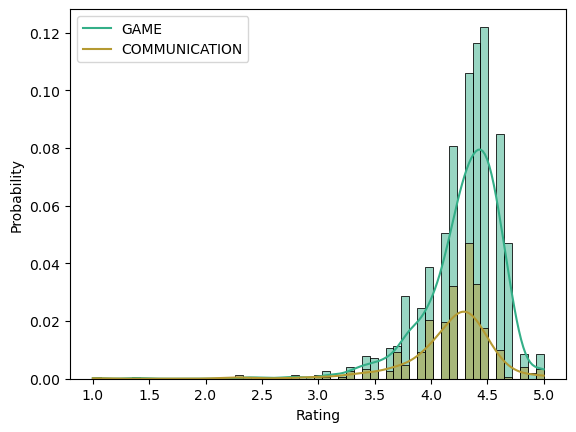

In [26]:
fig = sns.histplot(com_game_df, x="Rating", hue="Category", kde=True, stat="probability")
plt.legend(["GAME", "COMMUNICATION"])
plt.show()


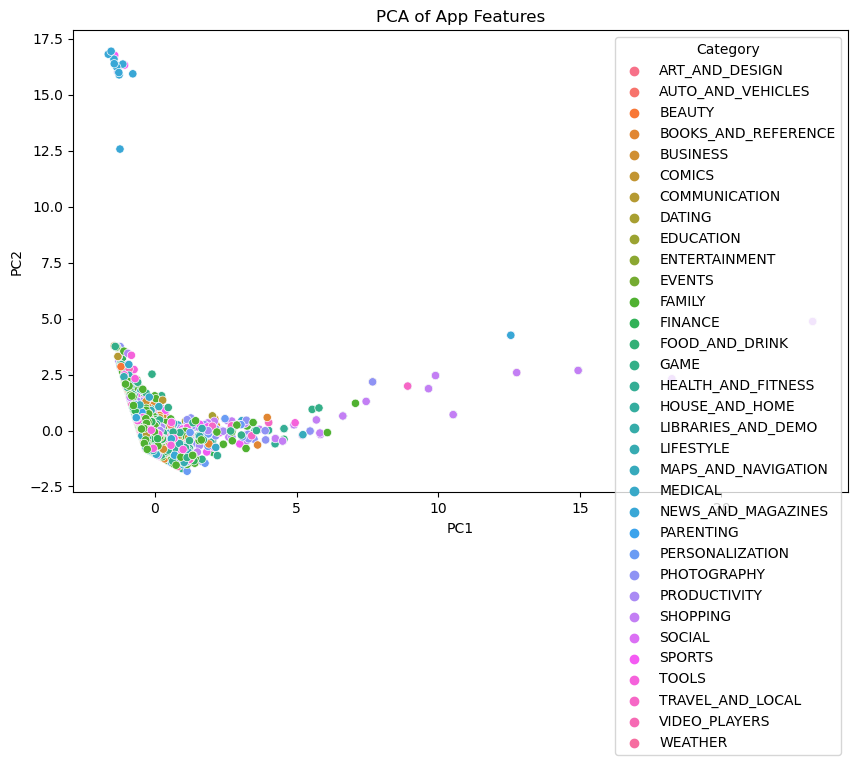

In [27]:
# PCA
features = ['Rating', 'Reviews', 'Size', 'Installs', 'Price']
x = data.loc[:, features].dropna().values
x = StandardScaler().fit_transform(x)

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data=principalComponents, columns=['PC1', 'PC2'])
finalDf = pd.concat([principalDf, data[['Category']]], axis=1)

plt.figure(figsize=(10, 6))
sns.scatterplot(x='PC1', y='PC2', hue='Category', data=finalDf)
plt.title('PCA of App Features')
plt.show()

PCA: The scatter plot shows distinct clustering of app categories in the principal component space, indicating the ability of PCA to reduce dimensionality while preserving category separation.

In [28]:
# Regularization
data_clean = data.dropna(subset=features)
y = data_clean['Rating']
X = data_clean[features]
X = sm.add_constant(X)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
lasso = Lasso(alpha=0.01)
ridge = Ridge(alpha=0.01)
elastic_net = ElasticNet(alpha=0.01)
lasso.fit(X_scaled, y)
ridge.fit(X_scaled, y)
elastic_net.fit(X_scaled, y)
print("Lasso coefficients:", lasso.coef_)
print("Ridge coefficients:", ridge.coef_)
print("Elastic Net coefficients:", elastic_net.coef_)

Lasso coefficients: [ 0.          0.53460298  0.          0.          0.         -0.        ]
Ridge coefficients: [ 0.00000000e+00  5.44602263e-01  4.38235335e-08  4.84133992e-08
  2.11122446e-09 -1.34627418e-08]
Elastic Net coefficients: [ 0.          0.53691838  0.          0.          0.         -0.        ]


Regularization: Lasso, Ridge, and Elastic Net regressions show that the number of reviews is the most influential factor on app ratings. The coefficients for other variables are shrunk to zero, indicating their lesser impact.

In [29]:
# Logistic Regression
data['HighRating'] = (data['Rating'] >= 4.0).astype(int)
X = data[['Reviews', 'Size', 'Installs', 'Price']].dropna()
y = data['HighRating'].loc[X.index]
X = sm.add_constant(X)
logit_model = sm.Logit(y, X).fit()
print(logit_model.summary())

Optimization terminated successfully.
         Current function value: 0.505084
         Iterations 11
                           Logit Regression Results                           
Dep. Variable:             HighRating   No. Observations:                 7723
Model:                          Logit   Df Residuals:                     7718
Method:                           MLE   Df Model:                            4
Date:                Sun, 09 Jun 2024   Pseudo R-squ.:                 0.06976
Time:                        11:08:51   Log-Likelihood:                -3900.8
converged:                       True   LL-Null:                       -4193.3
Covariance Type:            nonrobust   LLR p-value:                2.705e-125
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.8620      0.038     22.391      0.000       0.787       0.937
Reviews     1.023e-05   8.49

Logistic Regression: The model indicates that the number of reviews significantly predicts high ratings (p < 0.001). However, size and price do not significantly affect the likelihood of an app receiving a high rating.

#### Recommendations
* Focus on User Experience: Ensuring high app quality and user satisfaction is crucial for achieving higher ratings and more installations.
* Strategic Category Selection: Developers should consider targeting popular categories with high user engagement potential.
* Monetization Strategies: Free apps can achieve widespread adoption, but developers should explore various monetization strategies to convert high installation numbers into revenue.


#### Conclusion
Our analysis provides valuable insights into the factors that contribute to an app's success on the Google Play Store. By focusing on user experience, strategic category selection, and effective monetization strategies, app developers can enhance their chances of success in a competitive market.